In [280]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow import keras
from skimage import io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
import imgaug.augmenters as iaa
from matplotlib import image as mpimg
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D, Dropout
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix

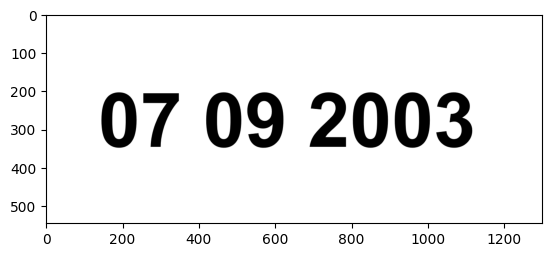

In [297]:
img = cv2.imread("drive/MyDrive/test_img_s.png")
# model = joblib.load('drive/MyDrive/number_recognition.pkl')
model_nr = keras.models.load_model('drive/MyDrive/number_recognition.h5')
def prediksi(image):
  image = cv2.resize(image, (28, 28))
  img_bob = image / 255
  bob = np.reshape(img_bob, (1, 28, 28, 1))
  pred = np.argmax(model_nr.predict(bob))
  return pred

plt.imshow(img)

1/1 [==============================] - 0s 54ms/step


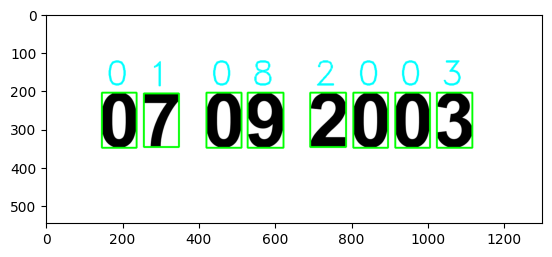

In [299]:
def ob_pred(img, mdl):
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
  ret, img_th = cv2.threshold(img_gray, 90, 255, cv2.THRESH_BINARY_INV)
  ctrs, _ = cv2.findContours(img_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  rects = [cv2.boundingRect(ctr) for ctr in ctrs]
  for rect in rects:
    cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 3)
    img_bob = img_th[rect[1]-10:rect[1]+rect[3]+10, rect[0]-10:rect[0]+rect[2]+10]
    nbr = mdl(img_bob)
    cv2.putText(img, str(int(nbr)), (rect[0] + 10, rect[1] - 20), cv2.FONT_HERSHEY_DUPLEX, 3, (0, 255, 255), 2)
  plt.imshow(img)

ob_pred(img, prediksi)

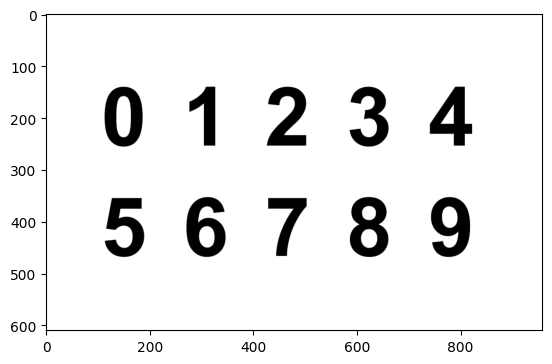

In [283]:
def find_contours(image):
  img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
  ret, img_th = cv2.threshold(img_gray, 90, 255, cv2.THRESH_BINARY_INV)

  ctrs, _ = cv2.findContours(img_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  rects = [cv2.boundingRect(ctr) for ctr in ctrs]
  y = []

  for rect in rects:
    img_bob = img_th[rect[1]-25:rect[1]+rect[3]+25, rect[0]-55:rect[0]+rect[2]+55]
    img_bob = cv2.resize(img_bob, (28, 28))
    y.append(img_bob)
  return y

img_1 = cv2.imread("drive/MyDrive/Sample_TL_3.png")
plt.imshow(img_1)
plt.show()

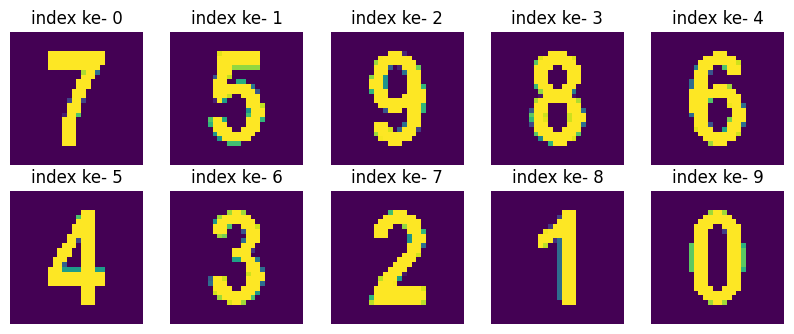

In [284]:
y_1 = find_contours(img_1)
plt.figure(figsize=(10, 10))
for i in range(len(y_1)):
  plt.subplot(len(y_1) // 2, len(y_1) // 2, i+1)
  plt.title("index ke- " + str(i))
  plt.axis("off")
  plt.imshow(y_1[i])
plt.show()

In [285]:
def augment_data(image, num_augmented_images=1000):
  img = image
  augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(rotate=(-25, 25)),
    iaa.GaussianBlur(sigma=(0, 0.8)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.03*255)),
  ])
  augmented_images = []
  for i in range(num_augmented_images):
    augmented_img = augmenter.augment_image(img)
    augmented_images.append(augmented_img)
  return augmented_images

def split_list(input_list, num_parts):
  avg = len(input_list) / float(num_parts)
  result = []
  last = 0.0
  while last < len(input_list):
    result.append(input_list[int(last):int(last + avg)])
    last += avg
  return result

zero = augment_data(y_1[9])
one = augment_data(y_1[8]) + split_list(augment_data(y_1[8]), 2)[0]
two = augment_data(y_1[7]) * 3 + split_list(augment_data(y_1[7]), 2)[0]
three = augment_data(y_1[6]) * 2
four = augment_data(y_1[5])
five = augment_data(y_1[1]) * 2 + split_list(augment_data(y_1[1]), 2)[0]
six= augment_data(y_1[4]) * 2
seven = augment_data(y_1[0]) * 2
eight = augment_data(y_1[3])
nine = augment_data(y_1[2])

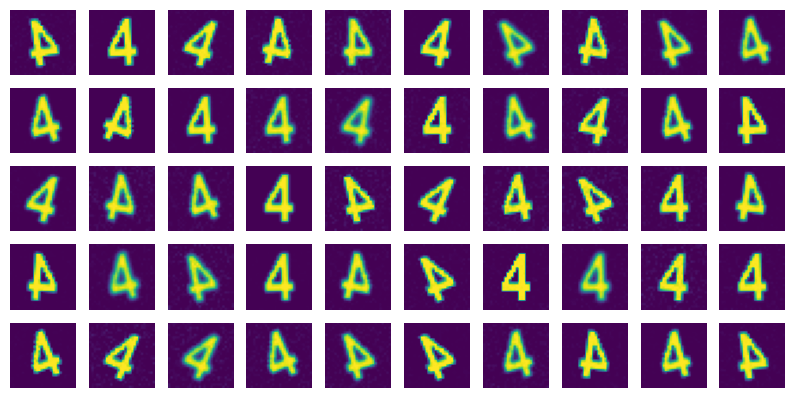

In [286]:
plt.figure(figsize=(10, 10))
for i in range(50):
  plt.subplot(10, 10, i+1)
  plt.axis("off")
  plt.imshow(four[50+i])
plt.show()

In [287]:
list_images = zero + one + two + three + four + five + six + seven + eight + nine
list_labels = ["0"]*len(zero) + ["1"]*len(one) + ["2"]*len(two) + ["3"]*len(three) + ["4"]*len(four) + ["5"]*len(five) + ["6"]*len(six) + ["7"]*len(seven) + ["8"]*len(eight) + ["9"]*len(nine)
random.seed(212)
combined_data = list(zip(list_images, list_labels))
random.shuffle(combined_data)
images, labels = zip(*combined_data)
images = list(images)
labels = list(labels)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
def preprocess_image(image):
  image = image / 255.0
  return image
train_images = [preprocess_image(image) for image in train_images]
test_images = [preprocess_image(image) for image in test_images]
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
train_images = np.array(train_images)
test_images = np.array(test_images)
print("Train Images Shape:", train_images.shape)
print("Test Images Shape:", test_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Labels Shape:", test_labels.shape)

Train Images Shape: (14000, 28, 28)
Test Images Shape: (3500, 28, 28)
Train Labels Shape: (14000, 10)
Test Labels Shape: (3500, 10)


In [288]:
def create_model():
  model = Sequential()
  model.add(model_nr)
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  for layer in model_nr.layers:
      layer.trainable = False
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model = create_model()
model.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10)                1748458   
                                                                 
 flatten_25 (Flatten)        (None, 10)                0         
                                                                 
 dense_83 (Dense)            (None, 128)               1408      
                                                                 
 dense_84 (Dense)            (None, 64)                8256      
                                                                 
 dense_85 (Dense)            (None, 10)                650       
                                                                 
Total params: 1,758,772
Trainable params: 10,314
Non-trainable params: 1,748,458
_________________________________________________________________


In [289]:
history = model.fit(train_images, train_labels, epochs=50, batch_size=32, validation_split=0.3)

Epoch 1/50
307/307 [==============================] - 10s 31ms/step - loss: 1.7405 - accuracy: 0.3524 - val_loss: 1.2917 - val_accuracy: 0.5279
Epoch 2/50
307/307 [==============================] - 7s 23ms/step - loss: 1.3178 - accuracy: 0.4908 - val_loss: 1.0561 - val_accuracy: 0.6262
Epoch 3/50
307/307 [==============================] - 9s 28ms/step - loss: 1.2136 - accuracy: 0.5272 - val_loss: 0.9380 - val_accuracy: 0.7060
Epoch 4/50
307/307 [==============================] - 7s 23ms/step - loss: 1.1555 - accuracy: 0.5550 - val_loss: 0.8839 - val_accuracy: 0.7188
Epoch 5/50
307/307 [==============================] - 7s 23ms/step - loss: 1.1176 - accuracy: 0.5667 - val_loss: 0.8226 - val_accuracy: 0.7050
Epoch 6/50
307/307 [==============================] - 6s 20ms/step - loss: 1.0919 - accuracy: 0.5813 - val_loss: 0.7856 - val_accuracy: 0.7667
Epoch 7/50
307/307 [==============================] - 9s 29ms/step - loss: 1.0575 - accuracy: 0.5913 - val_loss: 0.7483 - val_accuracy: 0.745

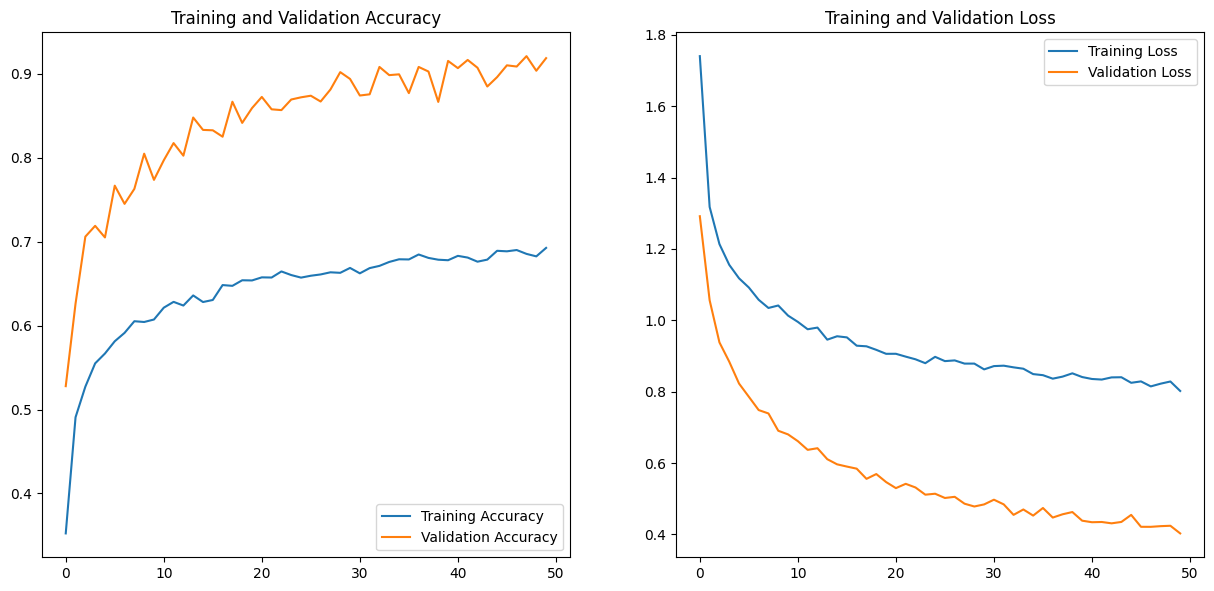

In [290]:
epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

110/110 [==============================] - 1s 12ms/step


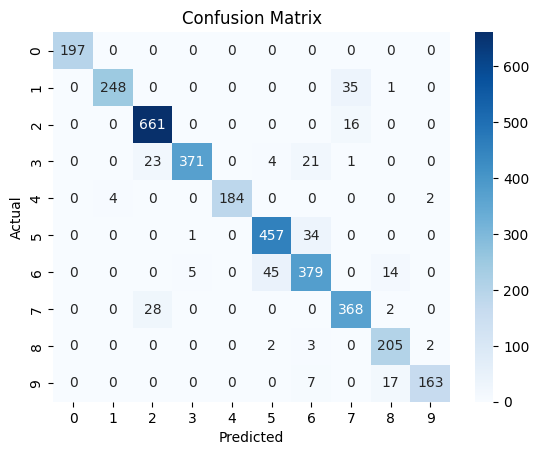

In [291]:
kelas = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
test_loss, test_acc = model.evaluate(test_images, test_labels)
y_pred = model.predict(test_images)
cm = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=kelas, yticklabels=kelas)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [294]:
def prediksi_n(image):
  image = cv2.resize(image, (28, 28))
  img_bob = image / 255
  bob = np.reshape(img_bob, (1, 28, 28, 1))
  pred = np.argmax(model.predict(bob))
  return pred

1/1 [==============================] - 0s 51ms/step


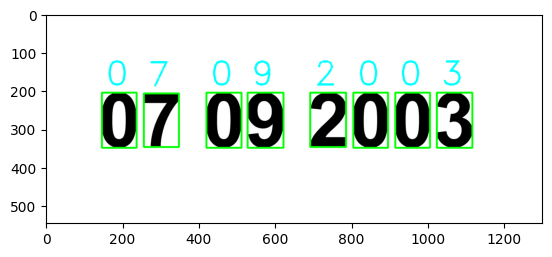

In [300]:
imgg = cv2.imread("drive/MyDrive/test_img_s.png")
ob_pred(imgg, prediksi_n)